In [1]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
from astropy.io import fits
import os
from lsst.geom import Point2I, Extent2I, Box2I

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [3]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [4]:
def readEtravelerCTE(filename):
    # Read the data extracted from the eTraveler files and return a dictionary with the results
    numamps = 16
    arr = numpy.loadtxt(filename, 'str')
    data = ['amp', 'cti_high_parallel', 'cti_high_parallel_error', 'cti_high_serial',\
            'cti_high_serial_error','cti_low_parallel', 'cti_low_parallel_error', \
            'cti_low_serial', 'cti_low_serial_error']
    return_data = {}
    for name in data:
        if name == 'amp':
            return_data[name] = numpy.zeros([numamps], dtype='int')
        else:
            return_data[name] = numpy.zeros([numamps], dtype='float')
         
    for i in range(numamps):
        for j,name in enumerate(data):
            index = i * len(data) + j
            if name == 'amp':
                return_data[name][i] = int(arr[index][4])
            else:
                return_data[name][i] = float(arr[index][4])
    return return_data


In [5]:
def findFitsFiles(basedir, rawname, lsst_num):
    # Finds the right fits files in the repo dir and returns the visit number
    low_counts = 1000
    high_counts = 100000
    base = basedir + 'raw/'+rawname+'/'
    for f in os.listdir(base):
        fits_file = fits.open(os.path.join(base, f))
        fits_lsst_num = fits_file[0].header['LSST_NUM']
        if fits_lsst_num != lsst_num: continue
        val = fits_file[1].header['AVERAGE']
        bias = fits_file[1].header['AVGBIAS']
        val = val - bias
        if val > low_counts:
            low_file = int(f.split('-')[0])
            low_counts = 1E7
        if val > high_counts:
            high_file = int(f.split('-')[0])
            high_counts = 1E7
    return (low_file, high_file)


In [13]:
# E2V
# These values are for the E2V detector

E2V_BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
rawname = '7086'
lsst_num = 'E2V-CCD250-175'
E2V_OFFSET = 10
E2V_Xsize = 512
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)
         }
(E2V_low_file, E2V_high_file) = findFitsFiles(E2V_BOOTCAMP_REPO_DIR, rawname, lsst_num)
filename = '/project/bootcamp/cslage/E2V-CCD250-175_CTE.txt'
E2V_cte_data = readEtravelerCTE(filename)


In [12]:
#ITL
# These values are for the ITL detector

ITL_BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-011/'
rawname = '5943D'
lsst_num = 'ITL-3800C-083-Dev'
ITL_OFFSET = 20
ITL_Xsize = 509
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)
         }

(ITL_low_file, ITL_high_file) = findFitsFiles(ITL_BOOTCAMP_REPO_DIR, rawname, lsst_num)
filename = '/project/bootcamp/cslage/ITL-3800C-083_CTE.txt'
ITL_cte_data = readEtravelerCTE(filename)


# Getting Horizontal CTE

In [8]:
def getOverscans(OFFSET, detector):
    overscans2 = {}
    for key, value in flipXY.items():
        bbox = detector[key].getRawHorizontalOverscanBBox()
        if value[0]:
            point = Point2I(bbox.getMinX(), bbox.getMinY())
            ext = Extent2I(bbox.getWidth() + OFFSET, bbox.getHeight())
            new_bbox = Box2I(point, ext)
            overscans2[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
        else:
            point = Point2I(bbox.getMinX() - OFFSET, bbox.getMinY())
            ext = Extent2I(bbox.getWidth() + OFFSET, bbox.getHeight())
            new_bbox = Box2I(point, ext)
        overscans2[key] = raw[new_bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image
    return overscans2


In [9]:
def compute_Serial_CTE(overscans2, xsize):
    cte_mean = []
    cte_std = []
    for i in range(1,17):
        if i < 9:
            amp = 'C1{}'.format(i-1)
            arr = overscans2[amp].getArray()[2:1999,:]
            arr = numpy.flip(arr, axis=1)
        else:
            amp = 'C0{}'.format(16-i)
            arr = overscans2[amp].getArray()[2:1999,:]
        normed = numpy.maximum(arr - numpy.mean(arr[:,20:], axis=1).reshape(1997,1), 0)
        cte = numpy.sum(normed[:,10:14], axis=1) / normed[:,9] / xsize
        cte_mean.append(numpy.nanmean(cte))
        cte_std.append(numpy.nanstd(cte))
    return (cte_mean, cte_std)

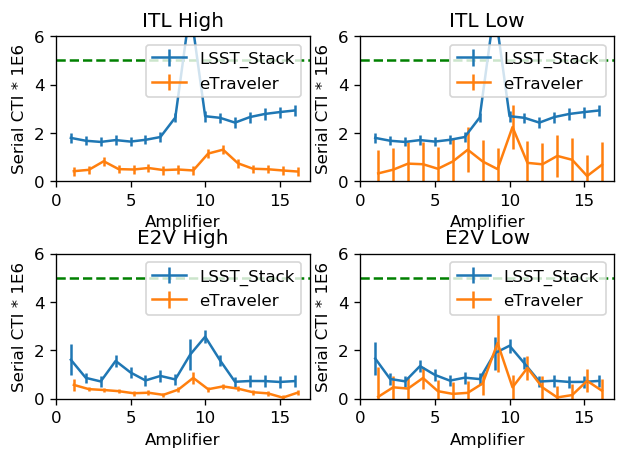

In [10]:
plotcounter = 1
for vendor in ['ITL', 'E2V']:
    if vendor == 'ITL':
        REPO_DIR = ITL_BOOTCAMP_REPO_DIR
        high_file = ITL_high_file
        low_file = ITL_low_file
        xsize = ITL_Xsize
        OFFSET = ITL_OFFSET
        cte_data = ITL_cte_data
    elif vendor == 'E2V':
        REPO_DIR = E2V_BOOTCAMP_REPO_DIR
        high_file = E2V_high_file
        low_file = E2V_low_file
        xsize = E2V_Xsize
        OFFSET = E2V_OFFSET
        cte_data = E2V_cte_data
 
    for flux in ['High', 'Low']:
        if flux == 'High':
            file = high_file
            eotest_mean = cte_data['cti_high_serial']
            eotest_std = cte_data['cti_high_serial_error']
        elif flux == 'Low':
            file = low_file
            eotest_mean = cte_data['cti_low_serial']
            eotest_std = cte_data['cti_low_serial_error']/10
            # eotest error bars are very large in low case, so I 
            # arbitrarily divided these by 10 to make the plot readable

        butler = Butler(REPO_DIR)
        dId = {'visit': file, 'detector': 2}
        raw = butler.get('raw', **dId)
        detector = raw.getDetector()
        overscans2 = getOverscans(OFFSET, detector)
        (cte_mean, cte_std) = compute_Serial_CTE(overscans2, xsize)
        plt.subplot(2,2,plotcounter)
        plt.subplots_adjust(hspace = 0.5)
        plt.title(vendor+' '+flux)
        plt.errorbar(cte_data['amp'],numpy.array(cte_mean)*1E6, yerr=numpy.array(cte_std)*1E6, label='LSST_Stack')
        plt.errorbar(cte_data['amp']+0.2,eotest_mean*1E6, yerr=eotest_std*1E6, label='eTraveler')
        plt.plot([0,17],[5.0,5.0],color='green',ls='--')
        plt.xlim(0,17)
        plt.ylim(0.0, 6.0)
        plt.xlabel('Amplifier')
        plt.ylabel('Serial CTI * 1E6')
        plt.legend()
        plotcounter += 1

